In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

1.12.0-rc2


# **Pre-processing**

**Download dataset**

In [0]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.boston_housing.load_data()

**Shuffle the training data**

In [0]:
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

**Dataset shape**

In [4]:
print('Dataset Shape:(No. of Examples, No. of Features)')
print('Training set:', train_data.shape)
print('Testing set: ' , test_data.shape)

Dataset Shape:(No. of Examples, No. of Features)
Training set: (404, 13)
Testing set:  (102, 13)


The dataset contains 13 different features:

1.   Per capita crime rate.
2.   The proportion of residential land zoned for lots over 25,000 square feet.
3.   The proportion of non-retail business acres per town.
4.   Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5.   Nitric oxides concentration (parts per 10 million).
6.   The average number of rooms per dwelling.
7.   The proportion of owner-occupied units built before 1940.
8.   Weighted distances to five Boston employment centers.
9.   Index of accessibility to radial highways.
10.  Full-value property-tax rate per $10,000.
11.  Pupil-teacher ratio by town.
12.  1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13.  Percentage lower status of the population.

**Visualise dataset**

In [5]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.07875,45.0,3.44,0.0,0.437,6.782,41.1,3.7886,5.0,398.0,15.2,393.87,6.68
1,4.55587,0.0,18.10,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12
2,0.09604,40.0,6.41,0.0,0.447,6.854,42.8,4.2673,4.0,254.0,17.6,396.90,2.98
3,0.01870,85.0,4.15,0.0,0.429,6.516,27.7,8.5353,4.0,351.0,17.9,392.43,6.36
4,0.52693,0.0,6.20,0.0,0.504,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63


First 10 label entries (**housing prices in thousands of dollars**)

In [6]:
print(train_labels[0:10])

[32.  27.5 32.  23.1 50.  20.6 22.6 36.2 21.8 19.5]


**Normalise the features** (*not* including test data)

In [7]:
mean = train_data.mean(axis=0) # axis 0 means over the 'column' axis
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # First training sample, normalized

[-0.39725269  1.41205707 -1.12664623 -0.25683275 -1.027385    0.72635358
 -1.00016413  0.02383449 -0.51114231 -0.04753316 -1.49067405  0.41584124
 -0.83648691]


# **Model**

**Model Architecture**

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(train_data.shape[1],)))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1))

**Compile**

In [0]:
model.compile(loss='mse', # loss: Mean Squared Error (MSE)
              optimizer=tf.train.RMSPropOptimizer(0.001),
              metrics=['mae']) # metric: Mean Absolute Error (MAE)

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


To **plot** MAE against Number of Epochs

To determine how long to train before the model stops making progress

In [0]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

Display training progress by printing a single dot for each completed epoch

In [0]:
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# **Post-processing**

**Training**

In [13]:
EPOCHS = 500

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats as history
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Plot training history

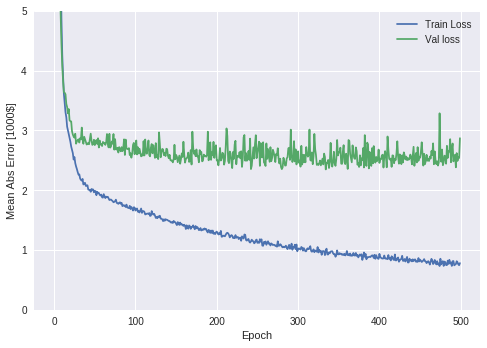

In [14]:
plot_history(history)

**Evaluate** - Returns the loss value & metrics values for the model

In [15]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

Testing set Mean Abs Error: $2649.24


**Predict** (test)

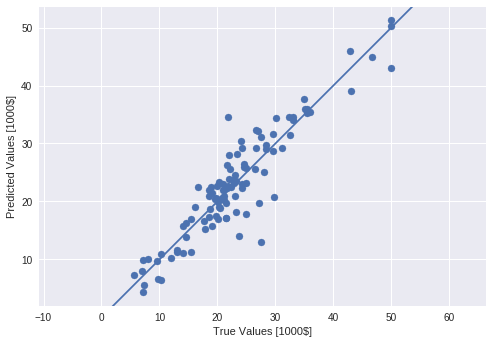

In [16]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [1000$]')
plt.ylabel('Predicted Values [1000$]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

**Analyse Error**

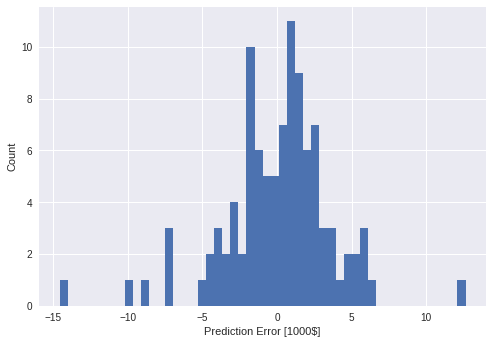

In [17]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [1000$]")
_ = plt.ylabel("Count")